In [4]:
import os
import yaml
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from types import SimpleNamespace
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import copy
import time
from PIL import Image
from zoneinfo import ZoneInfo
from datetime import datetime
from albumentations.core.transforms_interface import ImageOnlyTransform
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [5]:
# 1. YAML파일을 읽어 설정 반환
def load_config(config_path='./config.yaml'):
    with open(config_path, 'r') as file:
        cfg = yaml.safe_load(file)
    return SimpleNamespace(**cfg)

# 2. 랜덤성 제어
def set_seed(seed: int = 256):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 3. ImageDataset Class (Baseline 코드 동일)
class ImageDataset(Dataset):
    def __init__(self, df:pd.DataFrame, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df.iloc[idx]
        # img = np.array(Image.open(os.path.join(self.path, name)))
        img = Image.open(os.path.join(self.path, name))
        if self.transform:
            # img = self.transform(image=img)['image']
            img = self.transform(image=np.array(img))['image']
        return img, target

# 4. EarlyStopping Class (as requested)
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-6, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model_state_dict = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            #현재의 모델로 self.best_loss, self.best_model_state_dict 업데이트
            self.best_loss = val_loss
            self.best_model_state_dict = copy.deepcopy(model.state_dict())
        elif val_loss < self.best_loss - self.min_delta:
			#val_loss가 best_loss보다 좋을 때 > self.best_loss와 self.best_model 업데이트
            self.best_model_state_dict = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
			#val_loss가 더 안 좋을 때 > patience 증가하고 early stop 여부 확인
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights and self.best_model_state_dict is not None:
                    model.load_state_dict(self.best_model_state_dict)
                return True # ealy stopped
        return False # end with no early stop
    
    def restore_best(self, model):
        if self.best_loss is not None and self.best_model_state_dict is not None:
            print(f"Restore model_state_dict of which best_loss: {self.best_loss:.6f}")
            model.load_state_dict(self.best_model_state_dict)
            return True
        return False

class Morphological(ImageOnlyTransform):
    def __init__(self, scale=(1, 3), operation="dilation", always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.scale = scale
        self.operation = operation

    def apply(self, img, **params):
        # 커널 크기 랜덤 샘플링
        k = np.random.randint(self.scale[0], self.scale[1] + 1)
        kernel = np.ones((k, k), np.uint8)
        
        if self.operation == "dilation":
            return cv2.dilate(img, kernel, iterations=1)
        elif self.operation == "erosion":
            return cv2.erode(img, kernel, iterations=1)
        else:
            raise ValueError(f"Unsupported operation: {self.operation}")

    def get_transform_init_args_names(self):
        return ("scale", "operation")

A.Morphological = Morphological

def mixup_collate_fn(batch, num_classes=17, alpha=0.4):
    images, labels = zip(*batch)
    images = torch.stack(images)            # [B, C, H, W]
    labels = torch.tensor(labels)           # [B]

    lam = np.random.beta(alpha, alpha)
    batch_size = images.size(0)
    index = torch.randperm(batch_size)

    mixed_images = lam * images + (1 - lam) * images[index]

    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    mixed_labels = lam * labels_one_hot + (1 - lam) * labels_one_hot[index]

    return mixed_images, mixed_labels

def cutmix_collate_fn(batch, num_classes=17, alpha=1.0):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)

    lam = np.random.beta(alpha, alpha)
    batch_size, _, H, W = images.size()
    index = torch.randperm(batch_size)

    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    images[:, :, bby1:bby2, bbx1:bbx2] = images[index, :, bby1:bby2, bbx1:bbx2]
    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

    labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    mixed_labels = lam_adjusted * labels_one_hot + (1 - lam_adjusted) * labels_one_hot[index]

    return images, mixed_labels
    
# 5. Augmentation
def get_augmentation(cfg):
    common_resize_transform = A.Compose([
        # 긴 변을 기준으로 종횡비를 유지하며 resize
        A.LongestMaxSize(max_size=cfg.image_size),
        # cfg.image_size 정사각형으로 만들고, 여백은 흰색으로 채움.
        A.PadIfNeeded(min_height=cfg.image_size, min_width=cfg.image_size, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255), p=1.0),
        A.Normalize(mean=cfg.norm_mean, std=cfg.norm_std),
        ToTensorV2(),
    ])

    AUG = {
        'eda': A.Compose([
            # 공간 변형에 대한 증강
            A.ShiftScaleRotate(shift_limit=(-0.05,0.05), scale_limit=(-0.15, 0.15), rotate_limit=(-20, 30), value=(255,255,255), p=0.9),
            # x,y 좌표 반전 
            A.Transpose(p=0.5),
            # Blur & Noise
            A.OneOf([
                A.GaussianBlur(sigma_limit=(0.5, 2.5), p=1.0),
                A.Blur(blur_limit=(3, 9), p=1.0),
            ], p=0.3),
            A.GaussNoise(var_limit=(0.0025, 0.2), p=0.8),
            # Brightness, Contrast, ColorJitter
            A.ColorJitter(brightness=0.1, contrast=0.07, saturation=0.07, hue=0.07, p=0.8),
        ]),
        'dilation': A.Compose([
            A.Morphological(p=1, scale=(1, 3), operation="dilation"),
            # 공간 변형에 대한 증강
            A.ShiftScaleRotate(shift_limit=(-0.05,0.05), scale_limit=(-0.15, 0.15), rotate_limit=(-20, 30), value=(255,255,255), p=0.9),
            # x,y 좌표 반전 
            A.Transpose(p=0.5),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
            A.RandomBrightnessContrast(p=1),
        ]),
        'erosion': A.Compose([
            A.Morphological(p=1, scale=(2, 4), operation="erosion"),
            # 공간 변형에 대한 증강
            A.ShiftScaleRotate(shift_limit=(-0.05,0.05), scale_limit=(-0.15, 0.15), rotate_limit=(-20, 30), value=(255,255,255), p=0.9),
            # x,y 좌표 반전 
            A.Transpose(p=0.5),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
            A.RandomBrightnessContrast(p=1),
        ]),
        
    }

    train_transforms = []
    active_augs = [AUG[aug] for aug, active in cfg.augmentation.items() if active and aug in AUG]

    if cfg.online_augmentation:
        # online augmentation 학습 : 실시간으로 증강 기법을 적용하여, 더 다양한 증강 형태의 데이터를 학습할 수 있다.
        # 장점 : 무한한 다양성, 과적합 방지 효과 증대, 저장 공간 효율성
        # 단점 : 전처리 과정의 증가로 학습 시간 증가, 재현성이 떨어짐. 너무 많은 증강 기법을 적용하면, 의도치 않은 결과가 나올 수 있다.
        if active_augs:
            online_transform = A.Compose([
                A.OneOf(active_augs, p=0.85), # 85% 확률로 active_augs에 설정된 증강 기법들이 적용된다. 15% 확률로 원본 train 데이터를 사용한다.
                common_resize_transform # Resize 기법은 항상 동일하게.
            ])
            train_transforms.append(online_transform)
        else: # 따로 지정한 증강 기법이 없는 경우, Resize 기법만 사용
            train_transforms.append(common_resize_transform)
    else:
        # offline augmentation 학습 : 개별적으로 dataset을 만들어 ConcatDataset을 최종 생성한다. 모든 증강 기법을 적용 가능하고, 마치 데이터셋 개수 자체가 늘어난 것 같은 효과를 준다. (원래라면, 증강한 데이터를 저장해야 하지만 이건 생략.)
        # 단점 : 다양성 제한
        if active_augs:
            for aug_pipeline in active_augs: # 각각의 aug를 transform_func으로 만든다.
                train_transforms.append(A.Compose([aug_pipeline, common_resize_transform]))
        else:
            train_transforms.append(common_resize_transform)

    # validation 증강은 기본 증강만 사용한다.
    val_transform = common_resize_transform

    # Validation transform with 'eda' augmentation to simulate test conditions
    # tta_transform은 TTA에서도 사용할 증강이다.
    tta_transform = A.Compose([
        AUG['eda'],
        common_resize_transform
    ])

    return train_transforms, val_transform, tta_transform

# 6. Activation, Model, Criterion
def get_activation(activation_option):
    ACTIVATIONS = {
        'None': None,
        'ReLU': nn.ReLU, # 음수는 0으로, 양수는 선형함수
        'LeakyReLU': nn.LeakyReLU, # 음수도 일부 통과 -> Dead ReLU 방지
        'ELU': nn.ELU, # 음수도 일부 통과 → 출력 평균이 0에 가깝도록 함으로써 학습 안정화 도움
        'SELU': nn.SELU, # ELU에 스케일링 계수를 곱해 신경망을 자기 정규화, 특정 조건 (예: fully connected, 특정 초기화, 특정 구조)에서만 자기 정규화 효과가 잘 발휘
        'GELU': nn.GELU, # 더 부드러운 비선형성, Transformer, BERT류
        'Tanh': nn.Tanh, # 완만한 sigmoid
        'PReLU': nn.PReLU, # 음수도 일부 통과 -> Dead ReLU 방지, 기울기를 학습함.
        'SiLU': nn.SiLU, # 더 부드러운 비선형성, EfficientNet, Swin Transformer 등
    }
    return ACTIVATIONS[activation_option]

class TimmWrapper(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = timm.create_model(
            model_name=cfg.model_name,
            pretrained=cfg.pretrained,
            num_classes=0, global_pool='avg',
            act_layer=get_activation(cfg.timm['activation'])
        )
        self.dropout = nn.Dropout(p=cfg.custom_layer['drop'])
        self.activation = get_activation(cfg.custom_layer['activation'])()
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.num_features, 1024),
            nn.BatchNorm1d(1024),
            self.activation,
            self.dropout,
            nn.Linear(1024, 17)
        )
        def weight_init(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                if cfg.timm['activation'] in ['Tanh']:
                    # Xavier 초기화
                    init.xavier_uniform_(m.weight)
                else:
                    # He 초기화
                    init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
        if cfg.fine_tuning == 'head':
            # backbone 파라미터를 freeze
            for param in self.backbone.parameters():
                param.requires_grad = False
            # classifier는 가중치 초기화
            self.classifier.apply(weight_init)
        elif cfg.fine_tuning == 'custom':
            # 직접 커스터마이징
            pass
        elif cfg.fine_tuning == 'scratch':
            self.apply(weight_init)

    def forward(self, x):
        x = self.backbone(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

def get_timm_model(cfg):
    if hasattr(cfg, 'custom_layer') and cfg.custom_layer:
        return TimmWrapper(cfg).to(cfg.device)

    else: # timm 모델 구조 사용
        model = timm.create_model(
            cfg.model_name,
            pretrained=cfg.pretrained,
            num_classes=17,
            act_layer=get_activation(cfg.timm['activation'])
        )
        # 모델에 따라 'head'가 있는 것도 있고 없는 것도 있다.
        # 'head'가 있다면 dropout 비율을 설정할 수 있다.
        if cfg.timm.get('head', False):
            if cfg.timm['head'].get('drop'):
                model.head.drop.p = cfg.timm['head']['drop'] # classifier head의 dropout 설정
        return model.to(cfg.device)

def get_criterion(cfg):
    CRITERIONS = {
        "CrossEntropyLoss" : nn.CrossEntropyLoss()
    }
    return CRITERIONS[cfg.criterion]

def get_optimizer(model, cfg):
    # SGD, RMSprop, Momentum, NAG, Adam, AdamW, NAdam, RAdam, Adafactor
    # optimizer_params = {k: v for k, v in vars(cfg.optimizer_params).items()}
    OPTIMIZERS = {
        'SGD': optim.SGD(model.parameters(), lr=cfg.lr),
        'RMSprop': optim.RMSprop(model.parameters(), lr=cfg.lr, alpha=0.99, weight_decay=cfg.weight_decay),
        'Momentum': optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9),
        'NAG' : optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9, nesterov=True),
        'Adam' : optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay),
        'AdamW': optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay),
        'NAdam': optim.NAdam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, momentum_decay=4e-3),
        'RAdam': optim.RAdam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay),
        'Adafactor': optim.Adafactor(model.parameters(), lr=cfg.lr, beta2_decay=-0.8, d=1.0, weight_decay=cfg.weight_decay, maximize=False)
    }
    return OPTIMIZERS[cfg.optimizer_name]

def get_scheduler(optimizer, cfg, steps_per_epoch):
    # scheduler_params = {k: v for k, v in vars(cfg.scheduler_params).items()}
    # if cfg.scheduler_name == 'OneCycleLR':
    #     scheduler_params['steps_per_epoch'] = steps_per_epoch
    #     scheduler_params['epochs'] = cfg.epochs
    
    # StepLR, ExponentialLR, CosineAnnealingLR, OneCycleLR, ReduceLROnPlateau
    SCHEDULERS = {
        'StepLR': lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1),
        'ExponentialLR': lr_scheduler.ExponentialLR(optimizer, gamma=0.1),
        'CosineAnnealingLR': lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs, eta_min=0),
        'OneCycleLR': lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=steps_per_epoch, epochs=cfg.epochs),
        'ReduceLROnPlateau': lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=cfg.patience-5, min_lr=0),
    }
    return SCHEDULERS[cfg.scheduler_name]

In [6]:
class TrainModule():
	def __init__(self, model: torch.nn.Module, criterion, optimizer, scheduler, train_loader, valid_loader, cfg: SimpleNamespace, verbose:int =50, run=None):
		'''
		model, criterion, scheduler, train_loader, valid_loader 미리 정의해서 전달
		cfg : es_patience, epochs 등에 대한 hyperparameters를 namespace 객체로 입력
		'''
		required_attrs = ['scheduler_name','patience', 'epochs']
		for attr in required_attrs:
			assert hasattr(cfg, attr), f"AttributeError: There's no '{attr}' attribute in cfg."
		assert verbose > 1 and verbose < cfg.epochs, f"Logging frequency({verbose}) MUST BE smaller than EPOCHS({cfg.epochs}) and positive value."
		
		self.model = model
		self.criterion = criterion
		self.optimizer = optimizer
		self.scheduler = scheduler
		self.train_loader = train_loader
		self.valid_loader = valid_loader
		self.cfg = cfg
		if getattr(cfg, "device", False):
			self.model.to(self.cfg.device)
		else:
			self.cfg.device = 'cpu'
		self.es = EarlyStopping(patience=self.cfg.patience)
		### list for plot
		self.train_losses_for_plot, self.val_losses_for_plot = [], []
		self.train_acc_for_plot, self.val_acc_for_plot = [], [] # classification
		self.train_f1_for_plot, self.val_f1_for_plot = [], [] # classification
		# logging frequency
		self.verbose = verbose
		# wandb run object
		self.run = run
		# Mixed Precision > 'cuda' device 에서만 가능하다.
		self.scaler = torch.amp.GradScaler(enabled=self.cfg.mixed_precision) # 기본적으로 FP16에 최적화되어 있습니다.
		
	def training_step(self):
		# set train mode
		self.model.train()
		running_loss = 0.0
		correct = 0 # classification
		total = 0
		all_preds = []
		all_targets = []

		# mixup 또는 cutmix 활성화 여부 확인
		is_mixup_or_cutmix_enabled = (self.cfg.augmentation['mixup'] or self.cfg.augmentation['cutmix'])

		for train_x, train_y in self.train_loader: # batch training
			train_x, train_y = train_x.to(self.cfg.device), train_y.to(self.cfg.device)

			self.optimizer.zero_grad() # 이전 gradient 초기화

			with torch.amp.autocast(device_type='cuda', enabled=self.cfg.mixed_precision):
				outputs = self.model(train_x)
				loss = self.criterion(outputs, train_y)

			self.scaler.scale(loss).backward()
			self.scaler.step(self.optimizer)
			self.scaler.update() # 다음 반복을 위해 스케일 팩터를 업데이트

			# else:
			# 	outputs = self.model(train_x)
			# 	loss = self.criterion(outputs, train_y)
			# 	loss.backward() # backward pass
			# 	self.optimizer.step() # 가중치 업데이트

			if self.cfg.scheduler_name == "OneCycleLR":
				self.scheduler.step()

			running_loss += loss.item() * train_y.size(0)
			_, predicted = torch.max(outputs, 1) # 가장 확률 높은 클래스 예측 (정수 인덱스)

			# mixup/cutmix 활성화 여부에 따라 train_y 처리 분기
			if is_mixup_or_cutmix_enabled:
				# mixup/cutmix가 활성화된 경우, train_y는 소프트 레이블이므로 하드 레이블로 변환
				hard_train_y_for_metrics = torch.argmax(train_y, dim=1)
			else:
				# mixup/cutmix가 비활성화된 경우, train_y는 이미 하드 레이블 (정수)
				hard_train_y_for_metrics = train_y

			correct += (predicted == hard_train_y_for_metrics).sum().item() # 올바른 하드 레이블과 예측 비교
			total += hard_train_y_for_metrics.size(0)

			all_preds.extend(predicted.cpu().numpy())
			all_targets.extend(hard_train_y_for_metrics.cpu().numpy()) # metrics 계산을 위해 하드 레이블 사용

			# **********************************************
			# VRAM 부족 시: 각 배치 처리 후 GPU 캐시 비우기
			del train_x, train_y, outputs, loss # 사용된 변수 명시적 삭제
			torch.cuda.empty_cache() # <-- 여기에 추가
			# **********************************************

		epoch_loss = running_loss / total # average loss of 1 epoch
		epoch_acc = 100 * correct / total # classification
		epoch_f1 = f1_score(all_targets, all_preds, average='macro') # classification
		return epoch_loss, epoch_acc, epoch_f1 # classification
	
	def validation_step(self):
		self.model.eval()  # 평가 모드
		val_loss = 0
		correct = 0 # classification
		total = 0
		all_preds = []
		all_targets = []
		
		with torch.no_grad():  # gradient 계산 비활성화
			for val_x, val_y in self.valid_loader: # batch training
				val_x, val_y = val_x.to(self.cfg.device), val_y.to(self.cfg.device)
				
				# if self.cfg.mixed_precision: # FP16을 사용해 메모리 사용량 감소
				# autocast 컨텍스트 매니저 사용
				with torch.amp.autocast(device_type='cuda', enabled=self.cfg.mixed_precision):
					outputs = self.model(val_x)
					loss = self.criterion(outputs, val_y)
				# else:
				# 	outputs = self.model(val_x)
				# 	loss = self.criterion(outputs, val_y)
								
				val_loss += loss.item() * val_y.size(0)
				_, predicted = torch.max(outputs, 1) # classification
				correct += (predicted == val_y).sum().item() # classification
				total += val_y.size(0)

				all_preds.extend(predicted.cpu().numpy())
				all_targets.extend(val_y.cpu().numpy())

				# **********************************************
				# VRAM 부족 시: 각 배치 처리 후 GPU 캐시 비우기
				del val_x, val_y, outputs, loss # 사용된 변수 명시적 삭제
				torch.cuda.empty_cache()           # <-- 여기에 추가
				# **********************************************
		
		epoch_loss = val_loss / total # average loss of 1 epoch
		epoch_acc = 100 * correct / total # classification
		epoch_f1 = f1_score(all_targets, all_preds, average='macro') # classification
		return epoch_loss, epoch_acc, epoch_f1 # classification
	
	def training_loop(self):
		try:
			# reset loss list for plots
			self.train_losses_for_plot, self.val_losses_for_plot = [], []
			self.train_acc_for_plot, self.val_acc_for_plot = [], []
			epoch_counter = 0
			epoch_timer = []
			done = False
			
			pbar = tqdm(total=self.cfg.epochs)
			while not done and epoch_counter<self.cfg.epochs:
				st = time.time()
				epoch_counter += 1
				
				# train
				# train_loss = self.training_step() # regression
				train_loss, train_acc, train_f1 = self.training_step() # classification
				
				self.train_losses_for_plot.append(train_loss)
				self.train_acc_for_plot.append(train_acc) # classification
				self.train_f1_for_plot.append(train_f1) # classification

				# scheduler의 종류에 따라 val_loss를 전달하거나 그냥 step() 호출.
				if self.cfg.scheduler_name == "OneCycleLR":
					pass
				elif self.cfg.scheduler_name == "ReduceLROnPlateau":
					self.scheduler.step(val_loss)
				else:
					self.scheduler.step()

				# validation
				# val_loss = self.validation_step() # regression
				val_loss, val_acc, val_f1 = self.validation_step()  # classification
				self.val_losses_for_plot.append(val_loss)
				self.val_acc_for_plot.append(val_acc) # classification
				self.val_f1_for_plot.append(val_f1) # classification

				epoch_timer.append(time.time() - st)
				pbar.update(1)
				
				if self.run is not None:
					# print('wandb logging...')
					epoch_log = {
						'train_loss': train_loss,
						'train_accuracy': train_acc,
						'train_f1': train_f1,
						'val_loss': val_loss,
						'val_accuracy': val_acc,
						'val_f1': val_f1, 
						'learning_rate': self.optimizer.param_groups[0]['lr'],
					}

					# logging weights & gradients
					all_grads = []
					all_weights = []
					for param in self.model.parameters():
						if param.data is not None:
							all_weights.append(param.data.cpu().view(-1))
						if param.grad is not None:
							all_grads.append(param.grad.cpu().view(-1))
					if all_grads:
						epoch_log['weight/all'] = wandb.Histogram(torch.cat(all_weights))
					if all_weights:
						epoch_log['weights/all'] = wandb.Histogram(torch.cat(all_weights))
					
					self.run.log(epoch_log, step=epoch_counter) # wandb logging
				if epoch_counter == 1 or epoch_counter % self.verbose == 0:
					# self.verbose epoch마다 logging
					mean_time_spent = np.mean(epoch_timer)
					epoch_timer = [] # reset timer list
					# print(f"Epoch {epoch_counter}/{self.cfg.epochs} [Time: {mean_time_spent:.2f}s], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.8f}")
					print(f"Epoch {epoch_counter}/{self.cfg.epochs} [Time: {mean_time_spent:.2f}s], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.8f}\n Train ACC: {train_acc:.2f}%, Validation ACC: {val_acc:.2f}%\n Train F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}") # classification

				if self.es(self.model, val_loss):
					# early stopped 된 경우 if 문 안으로 들어온다.
					done = True
		except Exception as e:
			print(e)
			return False # training loop failed
		return True # training loop succeed
		
	def plot_loss(self, show:bool=False, savewandb:bool=True, savedir:str=None):
		"""loss, accuracy, f1-score에 대한 그래프 시각화 함수

		:param bool show: plt.show()를 실행할 건지, defaults to False
		:param bool savewandb: wandb logging에 plot을 시각화하여 저장할 건지, defaults to True
		:param str savedir: plot을 저장할 디렉토리를 설정, None이면 저장 안 함, defaults to None
		:return _type_: None
		"""
		import matplotlib.pyplot as plt
		fig, ax = plt.subplots(figsize=(6, 4))
		plt.plot(range(len(self.train_losses_for_plot)),self.train_losses_for_plot,color='blue',label='train_loss')
		plt.plot(range(len(self.val_losses_for_plot)),self.val_losses_for_plot,color='red',label='val_loss')
		plt.axhline(y=1e-3, color='red', linestyle='--', label='(Overfit)')
		plt.legend()
		plt.xlabel("Epoch")
		plt.ylabel("Loss")
		plt.title("Train/Validation Loss plot")
		if savedir is not None:
			if os.path.exists(savedir):
				os.makedirs(savedir, exist_ok=True)
			savepath = os.path.join(savedir, "loss_plot.png")
			plt.savefig(savepath)
			print(f"⚙️loss plot saved in {savepath}")
		if show:
			plt.show()
		if savewandb and self.run is not None:
			self.run.log({'loss_plot': wandb.Image(fig)}) # wandb
		plt.clf()
		
		# classification
		fig, ax = plt.subplots(figsize=(6, 4))
		plt.plot(range(len(self.train_acc_for_plot)),self.train_acc_for_plot,color='blue',label='train_acc')
		plt.plot(range(len(self.val_acc_for_plot)),self.val_acc_for_plot,color='red',label='val_acc')
		plt.axhline(y=99.0, color='red', linestyle='--', label='(99%)')
		plt.legend()
		plt.xlabel("Epoch")
		plt.ylabel("Accuracy(%)")
		plt.title("Train/Validation Accuracy Plot")
		plt.grid()
		if savedir is not None:
			savepath = os.path.join(savedir, "accuracy_plot.png")
			plt.savefig(savepath)
			print(f"⚙️accuracy plot saved in {savepath}")
		if show:
			plt.show()
		if savewandb and self.run is not None:
			self.run.log({'accuracy_plot': wandb.Image(fig)}) # wandb
		plt.clf()

		# classification
		fig, ax = plt.subplots(figsize=(6, 4))
		plt.plot(range(len(self.train_f1_for_plot)),self.train_f1_for_plot,color='blue',label='train_f1')
		plt.plot(range(len(self.val_f1_for_plot)),self.val_f1_for_plot,color='red',label='val_f1')
		plt.axhline(y=0.99, color='red', linestyle='--', label='(0.99)')
		plt.legend()
		plt.xlabel("Epoch")
		plt.ylabel("F1-score")
		plt.title("Train/Validation F1-score Plot")
		plt.grid()
		if savedir is not None:
			savepath = os.path.join(savedir, "f1_plot.png")
			plt.savefig(savepath)
			print(f"⚙️f1 plot saved in {savepath}")
		if show:
			plt.show()
		if savewandb and self.run is not None:
			self.run.log({'f1_plot': wandb.Image(fig)}) # wandb
		plt.clf()
		return None
		
	def save_experiments(self, savepath=None):
		""""""
		save_dict = {
			'model_state_dict': self.model.state_dict(),
			'optimizer_state_dict': self.optimizer.state_dict(),
			'scheduler_state_dict': self.scheduler.state_dict(),
			'cfg': vars(self.cfg) # 나중에 로드해서 CFG = SimpleNamespace(**cfg)로 복원
		}
		if savepath is not None:
			dirpath = os.path.dirname(savepath)
			if os.path.exists(dirpath):
				os.makedirs(dirpath, exist_ok=True)
			torch.save(save_dict, f=savepath)
			return True
		return False
		

In [7]:
### Offline augmentation
def augment_class_imbalance(cfg, train_df):
    # Cutout 증강 파이프라인 설정
    cutout_transform = A.Compose([
        # 이미지 크기 조정
        A.CoarseDropout(
            min_holes=1,
            max_holes=2,  # num_holes_range=(1, 2) 대신
            min_height=int(cfg.image_size * 0.05),
            max_height=int(cfg.image_size * 0.1),
            min_width=int(cfg.image_size * 0.05),
            max_width=int(cfg.image_size * 0.2),
            fill_value=(0, 0, 0),  # fill -> fill_value
            p=1.0
        )
    ])
    # 증강 대상 클래스
    augment_classes = cfg.class_imbalance['aug_class']
    max_samples = cfg.class_imbalance['max_samples']

    # 증강 이미지, 라벨, ID 리스트 초기화
    augmented_labels = []    # 증강된 이미지 라벨
    augmented_ids = []       # 증강된 이미지 ID
    total_augmented = 0
    # 증강 대상 클래스 루프
    for cls in augment_classes:
        print(cls, "클래스")
        cls_df = train_df[train_df['target'] == cls]
        current_count = len(cls_df)
        print("현재 개수:", current_count)
        # 목표 샘플 수에 도달하기 위해 필요한 증강 이미지 개수 계산
        # (current_count가 max_samples보다 많으면 0 또는 음수가 됨)
        to_generate = max_samples - current_count
        print("증강 개수:", to_generate)
        # 만약 현재 이미지 수가 목표치보다 많거나 같으면 증강할 필요 없으므로 다음 클래스로 넘어감
        if to_generate <= 0:
            continue
        # 증강할 이미지들을 원본 데이터프레임에서 샘플링 (중복 허용: replace=True)
        # 목표 샘플 수 (to_generate)만큼 이미지를 샘플링하며,
        # 만약 현재 이미지 개수(current_count)가 to_generate보다 적으면 중복 선택(replace=True)
        # 이 부분은 원래 코드의 `if/else` 조건문을 통합한 것입니다.
        sampled_df = cls_df.sample(n=to_generate, replace=False, random_state=cfg.random_seed).reset_index(drop=True)
        # 샘플링된 각 이미지에 대해 증강 수행 및 저장
        for idx, row in sampled_df.iterrows():
            img_id = row['ID']
            img_path = os.path.join(cfg.data_dir, 'train', img_id)
            # 이미지 로드 (OpenCV는 기본적으로 BGR로 로드)
            img = cv2.imread(img_path)
            # BGR 이미지를 RGB로 변환 (Albumentations는 RGB를 기대)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 정의된 Cutout 증강 적용
            augmented_img = cutout_transform(image=img)['image']

            # 증강된 이미지의 새로운 ID 생성 (기존 ID 앞에 'aug_' 접두사 추가)
            new_id = f"aug_{img_id}"
            save_path = os.path.join(cfg.data_dir, 'train', new_id)

            # 증강된 RGB 이미지를 다시 BGR로 변환하여 파일로 저장
            cv2.imwrite(save_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

            # 증강된 이미지의 라벨과 ID를 리스트에 추가
            augmented_labels.append(cls)
            augmented_ids.append(new_id)
            total_augmented += 1
        print(f"총 {total_augmented} 개의 이미지 증강")
    return augmented_ids, augmented_labels
def delete_offline_augmented_images(cfg, augmented_ids):
    train_dir = os.path.join(cfg.data_dir, 'train')
    _ = 0
    for filename in augmented_ids:
        file_path = os.path.join(train_dir, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            _ += 1
        else:
            print("Wrong filename:", file_path)
    print(_,"개 이미지 제거")


In [8]:
# 8. TTA & Inference
def tta_predict(model, dataset, tta_transform, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for enumidx, (image, _) in enumerate(tqdm(dataset, desc="TTA Prediction")): # load batch
            # read raw images from dataset_raw
            tta_preds = []
            image = image.clamp(0, 255).to(torch.uint8) 
            image = image.permute(1, 2, 0).cpu().numpy() # H,W,C 로 변형
            for _ in range(5): # 5 TTA iterations
                augmented_image = tta_transform(image=image)['image']
                augmented_image = augmented_image.to(device)
                augmented_image = augmented_image.unsqueeze(0) # batch, H,W,C 로 변형
                outputs = model(augmented_image) # inference
                tta_preds.append(outputs.softmax(1).cpu().numpy()) # append inference result
        
            avg_preds = np.mean(tta_preds, axis=0) # 5 TTA 예측 결과 확률값을 평균 낸다.
            predictions.extend(avg_preds.argmax(1))
    return predictions

def do_validation(df, model, data, transform_func, cfg, run=None, show=False, savepath=None):
    if cfg.TTA:
        print("Running TTA on validation set...")
        val_preds = tta_predict(model, data, transform_func, cfg.device)
    else:
        print("Running Normal Validation...")
        val_preds = predict(model, data, cfg.device)
    val_targets = df['target'].values
    val_f1 = f1_score(val_targets, val_preds, average='macro')
    # 메타데이터 로드
    meta = pd.read_csv(os.path.join(cfg.data_dir, 'meta.csv'))
    meta_dict = zip(meta['target'], meta['class_name'])
    meta_dict = dict(meta_dict)
    # meta_dict[-1] = "None"
    val_targets_class = list(map(lambda x: meta_dict[x], val_targets))
    val_preds_class = list(map(lambda x: meta_dict[x], val_preds))
    all_classes = sorted(list(set(val_targets_class + val_preds_class)))
    cm = confusion_matrix(val_targets_class, val_preds_class, labels=all_classes)
    plt.figure(figsize=(10, 8), dpi=100)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=all_classes, yticklabels=all_classes)
    plt.title(f"Validation Confusion Matrix - F1: {val_f1:.4f}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    if run:
        run.log({"tta_val_confusion_matrix": wandb.Image(plt)})
    if savepath is not None:
        plt.savefig(savepath)
    if show:
        plt.show()
    else:
        plt.clf()
    return val_preds, val_f1

def predict(model, loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Prediction"):
            images = images.to(device)
            outputs = model(images)
            predictions.extend(outputs.argmax(1).cpu().numpy())
    return predictions

In [9]:
### main code
project_root = '/data/ephemeral/home/upstageailab-cv-classification-cv_5'
cfg = load_config(
    config_path=os.path.join(project_root,'codes','config.yaml')
)
set_seed(cfg.random_seed)
device = 'cpu'
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
print("⚙️ Device :",device)
cfg.device = device

CURRENT_TIME = datetime.now(ZoneInfo("Asia/Seoul")).strftime("%y%m%d%H%M")
print(f"⌚ 실험 시간: {CURRENT_TIME}")

# W&B
next_run_name = f"{CURRENT_TIME}-{cfg.model_name}-opt_{cfg.optimizer_name}-sch_{cfg.scheduler_name}-img{cfg.image_size}-{'on' if cfg.online_augmentation else 'off'}aug_{'_'.join([aug for aug, active in cfg.augmentation.items() if active])}-clsaug_{1 if cfg.class_imbalance else 0}-TTA_{1 if cfg.TTA else 0}-MP_{1 if cfg.mixed_precision else 0}"
run = None # wandb 기록할 거면 True, 아니면 False.
if hasattr(cfg, 'wandb') and cfg.wandb['log']:
    run = wandb.init(
        project=cfg.wandb['project'],
        name=next_run_name,
        config=vars(cfg),
    )

### submission 폴더 생성
submission_dir = os.path.join(cfg.data_dir, 'submissions', next_run_name)
try:
    os.makedirs(submission_dir, exist_ok=False)
    # cfg에 추가 
    cfg.submission_dir = submission_dir
except:
    raise ValueError("같은 이름의 submission 폴더가 있습니다.", submission_dir)

print(cfg)
print(next_run_name)
if hasattr(cfg, 'class_imbalance') and cfg.class_imbalance:
    assert cfg.class_imbalance['max_samples'] <= 100, "Max_samples must be less than 73!"

⚙️ Device : cuda
⌚ 실험 시간: 2507071055


wandb: Currently logged in as: ahyeon1 (ahyeon1-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


namespace(model_name='resnet50.tv2_in1k', pretrained=True, fine_tuning='full', criterion='CrossEntropyLoss', optimizer_name='AdamW', lr=0.0001, weight_decay=1e-05, scheduler_name='CosineAnnealingLR', random_seed=256, n_folds=0, val_split_ratio=0.15, stratify=True, image_size=224, norm_mean=[0.5, 0.5, 0.5], norm_std=[0.5, 0.5, 0.5], class_imbalance={'aug_class': [1, 13, 14], 'max_samples': 78}, online_augmentation=True, augmentation={'eda': True, 'dilation': True, 'erosion': False, 'mixup': True, 'cutmix': False}, TTA=True, mixed_precision=True, timm={'activation': 'None'}, custom_layer=None, epochs=10000, patience=20, batch_size=32, wandb={'project': 'upstage-img-clf', 'log': True}, data_dir='/data/ephemeral/home/upstageailab-cv-classification-cv_5/data', device=device(type='cuda'), submission_dir='/data/ephemeral/home/upstageailab-cv-classification-cv_5/data/submissions/2507071055-resnet50.tv2_in1k-opt_AdamW-sch_CosineAnnealingLR-img224-onaug_eda_dilation_mixup-clsaug_1-TTA_1-MP_1')
2

In [10]:
# Data
df = pd.read_csv(os.path.join(cfg.data_dir, "train.csv"))
train_df, val_df = train_test_split(df, test_size=cfg.val_split_ratio, random_state=cfg.random_seed, stratify=df['target'] if cfg.stratify else None)

augmented_ids, augmented_labels = [], []
# 클래스 불균형 해소를 위한 이미지 offline 증강
if hasattr(cfg, 'class_imbalance') and cfg.class_imbalance:
    augmented_ids, augmented_labels = augment_class_imbalance(cfg, train_df)
    imb_aug_df = pd.DataFrame({
        "ID": augmented_ids,
        "target": augmented_labels
    })
    # 기존 train 데이터 프레임과 병합
    train_df = pd.concat([train_df, imb_aug_df], ignore_index=True)
    train_df = train_df.reset_index(drop=True)


1 클래스
현재 개수: 39
증강 개수: 39
총 39 개의 이미지 증강
13 클래스
현재 개수: 63
증강 개수: 15
총 54 개의 이미지 증강
14 클래스
현재 개수: 42
증강 개수: 36
총 90 개의 이미지 증강


In [11]:
train_transforms, val_transform, tta_transform = get_augmentation(cfg)

if cfg.online_augmentation:
    train_dataset = ImageDataset(train_df, os.path.join(cfg.data_dir, "train"), transform=train_transforms[0])
else:
    datasets = [ImageDataset(train_df, os.path.join(cfg.data_dir, "train"), transform=t) for t in train_transforms]
    train_dataset = ConcatDataset(datasets)

val_dataset = ImageDataset(val_df, os.path.join(cfg.data_dir, "train"), transform=val_transform)

# collate_fn 설정
if cfg.augmentation['mixup']:
    collate_fn = lambda batch: mixup_collate_fn(batch, num_classes=17, alpha=0.4)
elif cfg.augmentation['cutmix']:
    collate_fn = lambda batch: cutmix_collate_fn(batch, num_classes=17, alpha=1.0)
else:
    collate_fn = None

train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=4, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=4, pin_memory=True)

raw_transform = A.Compose([ToTensorV2()])
val_dataset_raw = ImageDataset(val_df, os.path.join(cfg.data_dir, "train"), transform=raw_transform)
val_loader_raw = DataLoader(val_dataset_raw, batch_size=cfg.batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [12]:
# Model
model = get_timm_model(cfg)
criterion = get_criterion(cfg)
optimizer = get_optimizer(model, cfg)
scheduler = get_scheduler(optimizer, cfg, steps_per_epoch=len(train_loader))

가져온 이미지 배치 크기: torch.Size([32, 3, 224, 224])
가져온 레이블 배치 크기: torch.Size([32, 17])
첫 번째 이미지의 레이블: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
두 번째 이미지의 레이블: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.9989, 0.0000, 0.0000, 0.0011, 0.0000])


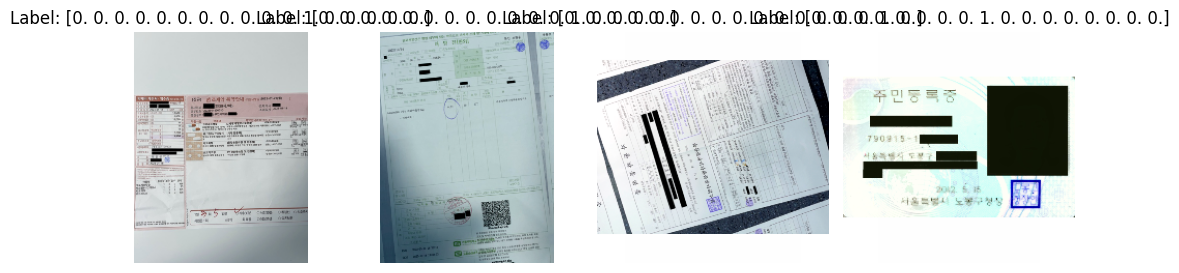


전체 배치 레이블 (소프트 레이블):
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.99885696 0.         0.         0.00114305 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.00114305 0.         0.         0.99885696 0.        ]
 [0.         0.         0.         0.         0.         0.00114305
  0.         0.         0.99885696 0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.00114305 0.         0.         0.99885696 0.
  0.         0.     

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# train_loader에서 첫 번째 배치 가져오기
train_images, train_labels = next(iter(train_loader))

print(f"가져온 이미지 배치 크기: {train_images.shape}")
print(f"가져온 레이블 배치 크기: {train_labels.shape}")
print(f"첫 번째 이미지의 레이블: {train_labels[0]}")
print(f"두 번째 이미지의 레이블: {train_labels[1]}")

# 이미지가 정규화되어 있다면, 시각화를 위해 역정규화 필요
norm_mean = cfg.norm_mean
norm_std = cfg.norm_std

def unnormalize(image_tensor, mean, std):
    mean_tensor = torch.tensor(mean).view(3, 1, 1)
    std_tensor = torch.tensor(std).view(3, 1, 1)
    image_tensor = image_tensor * std_tensor + mean_tensor
    return image_tensor.permute(1, 2, 0) # CHW -> HWC

plt.figure(figsize=(10, 5))
for i in range(min(4, train_images.shape[0])): # 처음 4개 이미지 시각화
    ax = plt.subplot(1, 4, i + 1)
    
    display_image = unnormalize(train_images[i].cpu(), norm_mean, norm_std).numpy()
    display_image = np.clip(display_image, 0, 1)

    plt.imshow(display_image)
    plt.title(f"Label: {train_labels[i].cpu().numpy().round(2)}")
    plt.axis("off")
plt.tight_layout()
plt.show()

print("\n전체 배치 레이블 (소프트 레이블):")
print(train_labels.cpu().numpy())

In [14]:
# Training
trainer = TrainModule(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    valid_loader=val_loader,
    cfg=cfg,
    verbose=15,
    run=run
)

train_result = trainer.training_loop()
if not train_result:
    if run:
        run.finish()
    if augmented_ids:
        ### Offline Augmentation 파일 삭제
        delete_offline_augmented_images(cfg=cfg, augmented_ids=augmented_ids)
    raise ValueError("Failed to train model...")

## 모델 저장
trainer.save_experiments(savepath=os.path.join(cfg.submission_dir, f'{next_run_name}.pth'))
## 학습 결과 시각화
trainer.plot_loss(
    show=False,
    savewandb=cfg.wandb['log'],
    savedir=cfg.submission_dir
)

  0%|          | 1/10000 [00:06<17:06:07,  6.16s/it]

Epoch 1/10000 [Time: 6.16s], Train Loss: 1.9185, Validation Loss: 0.93991568
 Train ACC: 48.17%, Validation ACC: 73.73%
 Train F1: 0.4672, Validation F1: 0.7126


  0%|          | 15/10000 [01:35<17:39:08,  6.36s/it]

Epoch 15/10000 [Time: 5.93s], Train Loss: 0.8806, Validation Loss: 0.29136386
 Train ACC: 82.94%, Validation ACC: 92.37%
 Train F1: 0.8264, Validation F1: 0.9184


  0%|          | 30/10000 [03:11<17:39:03,  6.37s/it]

Epoch 30/10000 [Time: 5.96s], Train Loss: 0.5764, Validation Loss: 0.27394865
 Train ACC: 92.91%, Validation ACC: 91.95%
 Train F1: 0.9281, Validation F1: 0.9174


  0%|          | 39/10000 [04:10<17:44:32,  6.41s/it]


⚙️loss plot saved in /data/ephemeral/home/upstageailab-cv-classification-cv_5/data/submissions/2507071055-resnet50.tv2_in1k-opt_AdamW-sch_CosineAnnealingLR-img224-onaug_eda_dilation_mixup-clsaug_1-TTA_1-MP_1/loss_plot.png
⚙️accuracy plot saved in /data/ephemeral/home/upstageailab-cv-classification-cv_5/data/submissions/2507071055-resnet50.tv2_in1k-opt_AdamW-sch_CosineAnnealingLR-img224-onaug_eda_dilation_mixup-clsaug_1-TTA_1-MP_1/accuracy_plot.png
⚙️f1 plot saved in /data/ephemeral/home/upstageailab-cv-classification-cv_5/data/submissions/2507071055-resnet50.tv2_in1k-opt_AdamW-sch_CosineAnnealingLR-img224-onaug_eda_dilation_mixup-clsaug_1-TTA_1-MP_1/f1_plot.png


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

# Grad-CAM 시각화

In [18]:
def visualize_gradcam(model, dataloader, num_images=10, device='cuda'):
    model.eval()
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)

    images_shown = 0

    for images, labels in dataloader:
        images = images.to(device)

        # mixup, cutmix soft label 처리
        if labels.dtype == torch.float:
            labels = labels.argmax(dim=1)
        labels = labels.to(device)

        preds = model(images).argmax(dim=1)

        plt.ion()

        # Figure 설정
        fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

        for i in range(num_images):
            if i >= images.size(0):
                break

            image = images[i].unsqueeze(0)
            label = labels[i].item()
            pred_label = preds[i].item()

            # Grad-CAM 실행 (pred_label 기준 시각화)
            targets = [ClassifierOutputTarget(pred_label)]
            grayscale_cam = cam(input_tensor=image, targets=targets)[0, :]

            # [0, 1] normalize
            image_rgb = image.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
            image_rgb = (image_rgb - image_rgb.min()) / (image_rgb.max() - image_rgb.min() + 1e-8)

            visualization = show_cam_on_image(image_rgb, grayscale_cam, use_rgb=True)

            # 이미지 표시
            axs[i, 0].imshow(image_rgb)
            axs[i, 0].set_title(f"Original | GT: {label} | Pred: {pred_label}")
            axs[i, 0].axis('off')

            axs[i, 1].imshow(visualization)
            axs[i, 1].set_title(f"Grad-CAM | GT: {label} | Pred: {pred_label}")
            axs[i, 1].axis('off')

        plt.tight_layout()
        plt.show()
        plt.ioff()
        return

## 훈련 데이터셋 10장 Grad-CAM

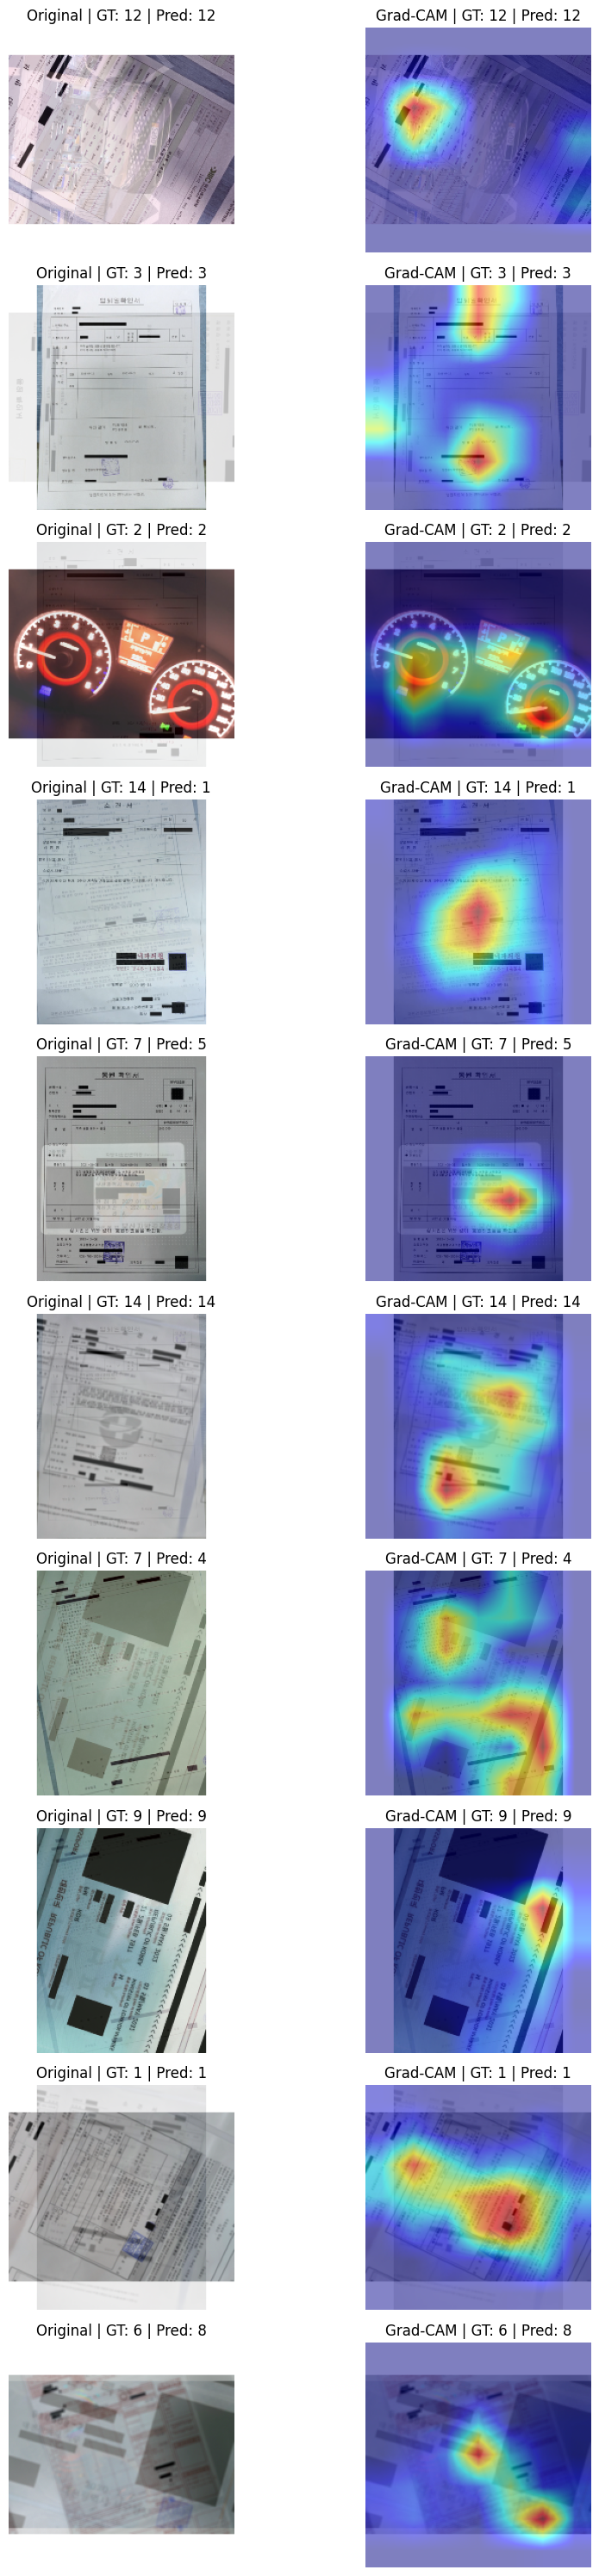

In [20]:
visualize_gradcam(trainer.model, train_loader, num_images=10, device='cuda')

## 검증 데이터셋 10장 Grad-CAM

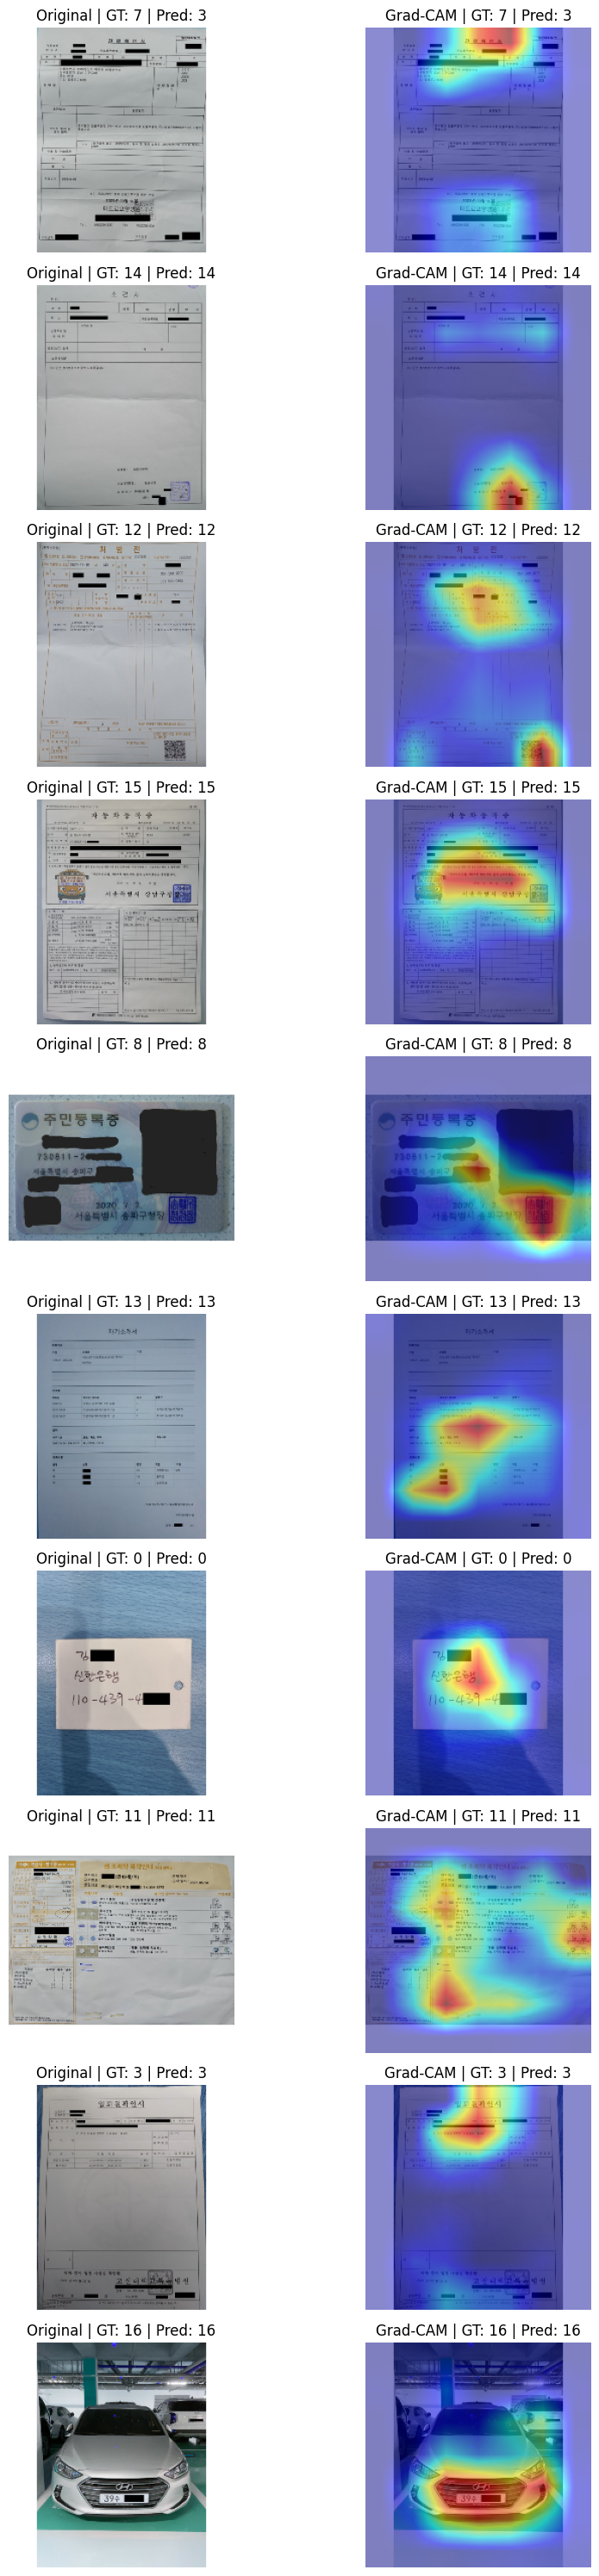

In [21]:
visualize_gradcam(trainer.model, val_loader, num_images=10, device='cuda')

In [14]:
val_preds, val_f1 = do_validation(
    df=val_df, 
    model=trainer.model, 
    data=val_dataset_raw if cfg.TTA else val_loader, 
    transform_func=tta_transform, 
    cfg=cfg, 
    run=run, 
    show=False, 
    savepath=os.path.join(cfg.submission_dir, f"val_confusion_matrix{'_TTA' if cfg.TTA else ''}.png")
)

Running TTA on validation set...


TTA Prediction: 100%|██████████| 236/236 [00:29<00:00,  8.12it/s]


In [15]:
# Inference
test_df = pd.read_csv(os.path.join(cfg.data_dir, "sample_submission.csv"))

if cfg.TTA:
    test_dataset_raw = ImageDataset(test_df, os.path.join(cfg.data_dir, "test"), transform=raw_transform)
    test_loader_raw = DataLoader(test_dataset_raw, batch_size=cfg.batch_size, shuffle=False, num_workers=4, pin_memory=True)
    print("Running TTA on test set...")
    test_preds = tta_predict(model, test_dataset_raw, tta_transform, device)
else:
    test_dataset = ImageDataset(test_df, os.path.join(cfg.data_dir, "test"), transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=4, pin_memory=True)
    print("Running inference on test set...")
    test_preds = predict(model, test_loader, device)

pred_df = pd.read_csv(os.path.join(cfg.data_dir, "sample_submission.csv"))
pred_df['target'] = test_preds

Running TTA on test set...


TTA Prediction: 100%|██████████| 3140/3140 [06:27<00:00,  8.11it/s]


In [16]:
# Submission
sample_submission_df = pd.read_csv(os.path.join(cfg.data_dir, "sample_submission.csv"))
assert (sample_submission_df['ID'] == pred_df['ID']).all(), "pred_df에서 test 이미지가 아닌 데이터가 존재합니다."
assert set(pred_df['target']).issubset(set(range(17))), "target 컬럼에 0~16 외의 값이 있습니다."

submission_path = os.path.join(cfg.submission_dir, f"{next_run_name}.csv")
pred_df.to_csv(submission_path, index=False)
print(f"📢Submission file saved to {submission_path}")

if run:
    # Log submission artifact
    artifact = wandb.Artifact(f'submission-{next_run_name}', type='submission')
    artifact.add_file(submission_path)
    run.log_artifact(artifact)
    run.finish()

📢Submission file saved to /data/ephemeral/home/upstageailab-cv-classification-cv_5/data/submissions/2507062140-resnet50.tv2_in1k-opt_AdamW-sch_CosineAnnealingLR-img384-onaug_eda_dilation_mixup-clsaug_1-TTA_1-MP_1/2507062140-resnet50.tv2_in1k-opt_AdamW-sch_CosineAnnealingLR-img384-onaug_eda_dilation_mixup-clsaug_1-TTA_1-MP_1.csv


In [ ]:
### Offline Augmentation 파일 삭제
delete_offline_augmented_images(cfg=cfg, augmented_ids=augmented_ids)

In [ ]:
# model load
### 저장된 trainer를 로드하여 추론하는 경우 아래 함수로 로드
# def load_checkpoint_model(savepath=None):
#     if os.path.exists(savepath):
#         checkpoint = torch.load(savepath)
#         cfg = SimpleNamespace(**checkpoint['cfg'])
#         model = get_timm_model(cfg)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         return model, cfg
#     else:
#         return None
    
# model, cfg = load_checkpoint_model(
#     savepath=os.path.join(project_root,'models','resnetrs101.tf_in1k-opt_Adam-img224-aug_0-2506301324-0001.pth')
# )